In [4]:
import os
import uuid
import numpy as np
from PIL import Image  # Import the Image class from the PIL (Pillow) library
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import Ftrl
import pandas as pd  # Import the Pandas library
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical


test_dir = "..\isec-ic\\dataset\\test"

current_dir = os.path.dirname(os.path.realpath(__file__ if '__file__' in locals() else os.getcwd()))
test_dir = os.path.join(current_dir, test_dir)
# , "earlyblight",  "targetspot"
categories = ["bacterialspot", "healthy",  "lateblight","leafmold", "mosaicvirus","yellowleafcurlvirus" ,"spidermite","septorialeafspot"]

model_path = './base_results/0.91375_f7e236c2-4602-4bfb-9d76-9ac47d633d83_model_adam_lr0.001_epochs100_lfsparse_categorical_crossentropy_64x64_nc1_64_elu_nc2_64_elu__8_classes.keras'
model = tf.keras.models.load_model(model_path)

In [7]:
def load_images_from_folder(folder):
    images = []
    labels = []
    subfolders = os.listdir(folder)  # list of subfolders in the main folder
    
    for subfolder in subfolders:
        category = subfolder.split("_")[-1].lower()  # category of the subfolder (e.g., "scab" from "Apple___Apple_scab")
        
        if category in categories:
            print("Loading images from category: " + category + " and subfolder: " + subfolder)
            subfolder_path = os.path.join(folder, subfolder)
            
            for filename in os.listdir(subfolder_path):
                img = Image.open(os.path.join(subfolder_path, filename))
                img = img.resize((64, 64)) # default is 256
                img = np.array(img) / 255.0  # normalization of the pixel values between 0 and 1
                images.append(img)
                labels.append(categories.index(category))  # index of the category in the list of categories
        else:
            print("Category: " + category + " from subfolder " + subfolder + " is not in the list of categories.")

    return np.array(images), np.array(labels)


x_test, y_test = load_images_from_folder(test_dir)
print("Finished to load the test images");

Loading images from category: bacterialspot and subfolder: tomato_bacterialspot
Category: earlyblight from subfolder tomato_earlyblight is not in the list of categories.
Loading images from category: healthy and subfolder: tomato_healthy
Loading images from category: lateblight and subfolder: tomato_lateblight
Loading images from category: leafmold and subfolder: tomato_leafmold
Loading images from category: mosaicvirus and subfolder: tomato_mosaicvirus
Loading images from category: septorialeafspot and subfolder: tomato_Septorialeafspot
Loading images from category: spidermite and subfolder: tomato_spidermite
Category: targetspot from subfolder tomato_targetspot is not in the list of categories.
Loading images from category: yellowleafcurlvirus and subfolder: tomato_yellowleafcurlvirus
Finished to load the test images


25/25 [==============================] - 0s 1ms/step
Global Accuracy: 91.38%


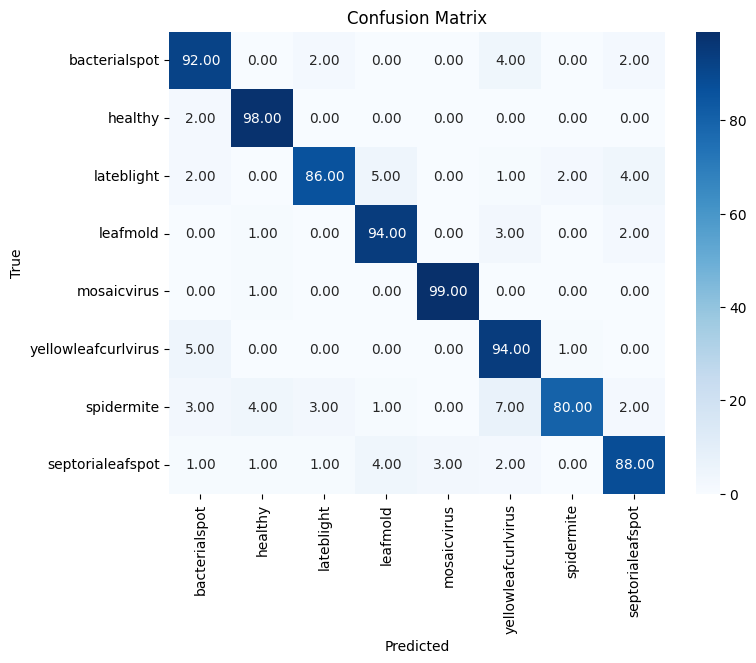

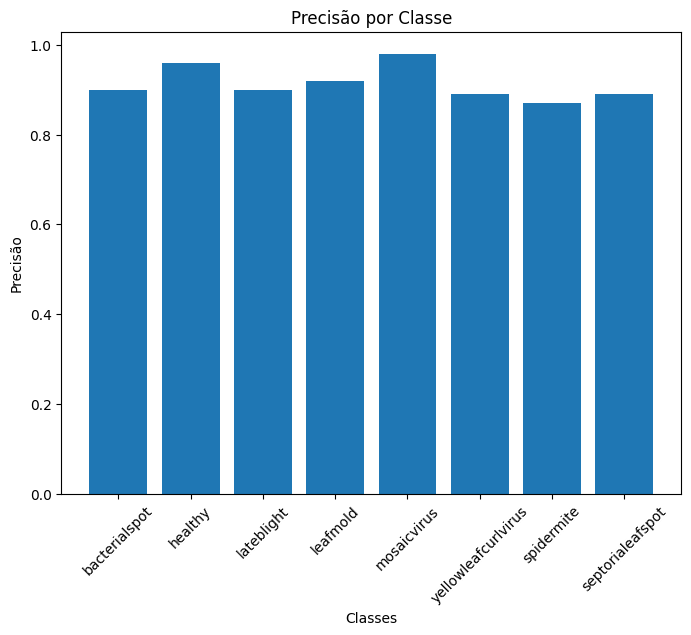

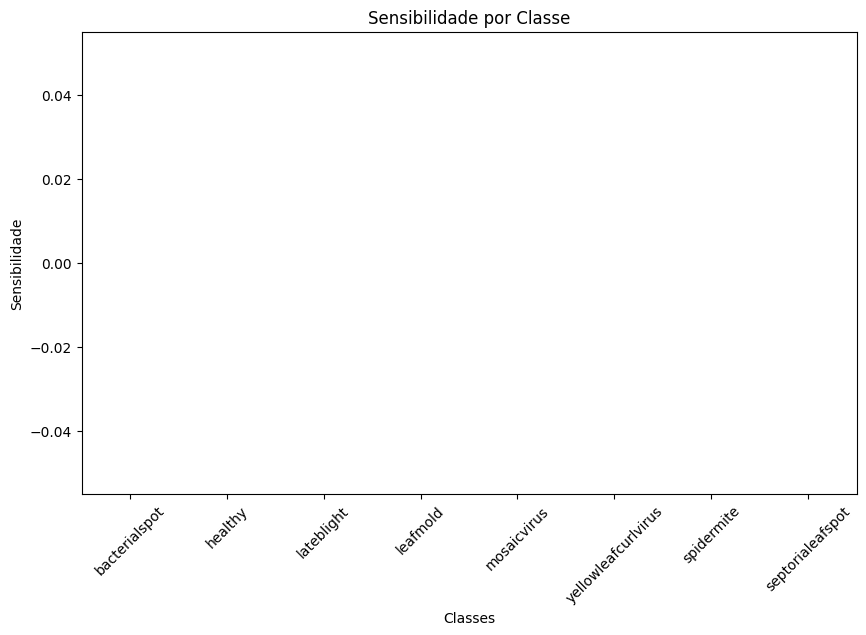

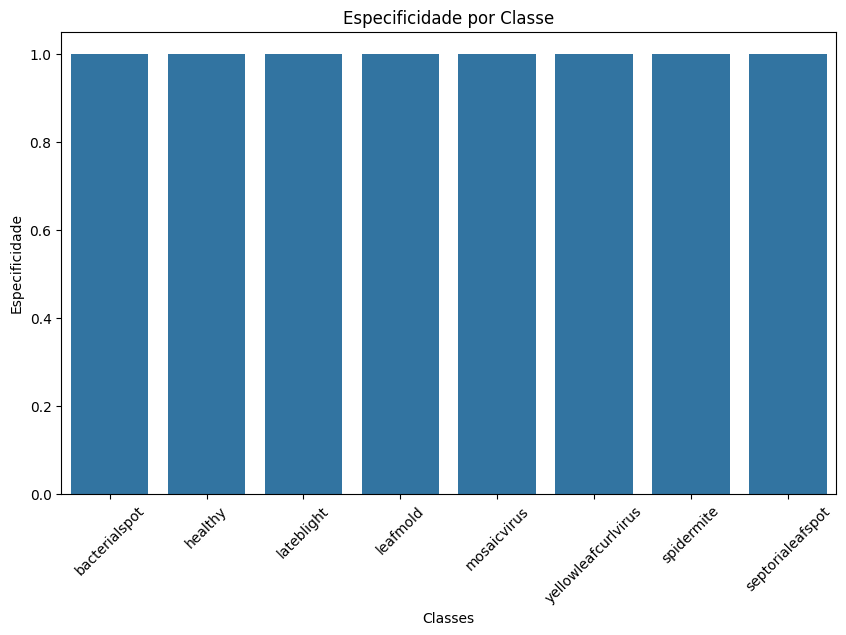

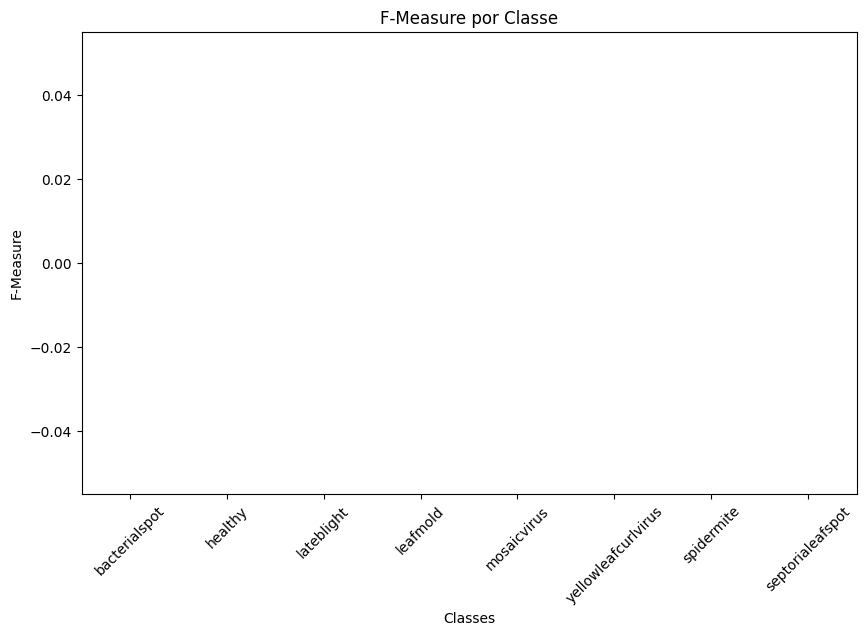

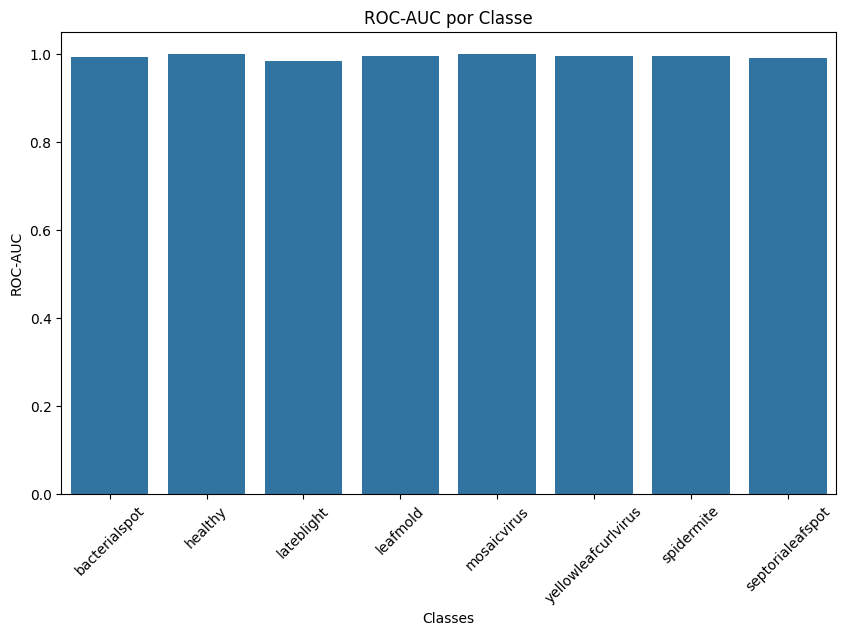

In [12]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

global_accuracy = accuracy_score(y_test, y_pred_classes)
print("Global Accuracy: {:.2f}%".format(global_accuracy * 100))

# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred_classes)
row_sums = confusion.sum(axis=1, keepdims=True)
percent_confusion = (confusion / row_sums) * 100
plt.figure(figsize=(8, 6))
sns.heatmap(percent_confusion, annot=True, fmt=".2f", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Precission report
classification = classification_report(y_test, y_pred_classes, target_names=categories, zero_division=1)
categories_classification = []
precision = []
lines = classification.split('\n')
for line in lines[2:-3]:
    parts = line.split()
    if len(parts) >= 4:
        category = parts[0]
        p = float(parts[3])
        categories_classification.append(category)
        precision.append(p)
plt.figure(figsize=(8, 6))
plt.bar(categories_classification, precision)
plt.xlabel('Classes')
plt.ylabel('Precisão')
plt.title('Precisão por Classe')
plt.xticks(rotation=45)
plt.show()


# Cálculo das métricas ROC-AUC, sensibilidade, especificidade, F-Measure e AUC
n_classes = len(categories)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array([1 if j == i else 0 for j in y_test]), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Convert the list of categories into a pandas Categorical object
categories_df = pd.Categorical(categories, categories=categories)

# Sensitivities, Specificities, F-Measures, and AUC
sensitivities = [tpr[i][0] for i in range(n_classes)]
specificities = [1 - fpr[i][0] for i in range(n_classes)]
f_measures = [2 * (s * p) / (s + p) for s, p in zip(sensitivities, specificities)]
roc_auc_values = [roc_auc[i] for i in range(n_classes)]

# Gráfico de Sensibilidade
plt.figure(figsize=(10, 6))
sns.barplot(x=categories_df, y=sensitivities)
plt.xlabel('Classes')
plt.ylabel('Sensibilidade')
plt.title('Sensibilidade por Classe')
plt.xticks(rotation=45)
plt.show()

# Gráfico de Especificidade
plt.figure(figsize=(10, 6))
sns.barplot(x=categories_df, y=specificities)
plt.xlabel('Classes')
plt.ylabel('Especificidade')
plt.title('Especificidade por Classe')
plt.xticks(rotation=45)
plt.show()

# Gráfico de F-Measure
plt.figure(figsize=(10, 6))
sns.barplot(x=categories_df, y=f_measures, errorbar='sd', capsize=0)  # Removido o cálculo do intervalo de confiança e as barras de erro
plt.xlabel('Classes')
plt.ylabel('F-Measure')
plt.title('F-Measure por Classe')
plt.xticks(rotation=45)
plt.show()

# Gráfico de AUC
plt.figure(figsize=(10, 6))
sns.barplot(x=categories_df, y=roc_auc_values)
plt.xlabel('Classes')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC por Classe')
plt.xticks(rotation=45)
plt.show()
